In [222]:
import pandas as pd
from pathlib import Path
import sqlalchemy as sa
from dotenv import load_dotenv
import os
import psutil
import regex as re
import numpy as np
from tqdm import tqdm
import datetime
import pickle
load_dotenv()

# set options for pandas and numpy formatting (no errors should occur if these are ommitted)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.mode.chained_assignment = None  # default='warn'
np.set_printoptions(formatter={'float':"{:6.5g}".format})

engine = sa.create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}"
			.format(host=os.getenv('host'), db=os.getenv('db'), user=os.getenv('uname'), pw=os.getenv('password')))

In [223]:
class Loan:
    ObservationNmb: int
    maturity_dt: datetime.date
    origination_dt: datetime.date
    lender_status: int
    all_pmts: np.ndarray
    
    def __init__(self, nmb, m_dt, o_dt, l_st,pmts):
        self.ObservationNmb = nmb
        self.maturity_dt = m_dt
        self.origination_dt = o_dt
        self.all_pmts = pmts
        self.lender_status = l_st
        
    def find_payoff_date(self):
        pass
 


## Building loans dictionary and pickle files

In [ ]:
def get_ids()-> list:
    with engine.connect() as con:
            con.execute('SET GLOBAL innodb_buffer_pool_size=2147483648;')
            # Get ObservationNmb's for all non-revolver loans
            query = """ SELECT elipsmisc7afoia.ObservationNmb, repymnttbl7afoia.MaturityDt, elipsmisc7afoia.LoanFundedDt, loantbl7afoia.LenderStatusCd FROM elipsmisc7afoia
                    JOIN repymnttbl7afoia
                    ON repymnttbl7afoia.ObservationNmb = elipsmisc7afoia.ObservationNmb
                    JOIN loantbl7afoia
                    ON loantbl7afoia.ObservationNmb = elipsmisc7afoia.ObservationNmb
                    WHERE RevolvingLineofCreditCd = 'N' AND YEAR(LoanFundedDt) >= 2000 ;"""
                    
            print("aggregating loan ids...\n")
            rows = con.execute(query)
            return [list(ele) for ele in rows.fetchall()]

# def format_ids(ids: list)-> list:
#     with engine.connect() as con:    
#         #format ids into a list of id strings (currently its a list of RowProxies)
#         print("formatting ids into querries...\n")
#         pattern = r"(\(\')(.+)\'"
#         ids = [str(x) for x in ids]
#         return [re.search(pattern, x).group(2) for x in ids]

ids = get_ids()


loans = {}

print("looping...\n")
with engine.connect() as con:    
    for id in tqdm(ids):
        con.execute('SET GLOBAL innodb_buffer_pool_size=2147483648;')
        query = f"""SELECT EffectiveDt, TransacionCd, GeneralLedgerCd, TransactionAmt, TransactionBalanceAmt FROM master_fin WHERE ObservationNmb = \"{id[0]}\" """
        result = con.execute(query)
        rows = np.array([list(ele) for ele in result])
        loans[id[0]] = Loan(id[0], id[1], id[2], id[3], rows)
        
        # DataStructure of Loan.pmt_history: 
        #   [
        #   [EffectiveDt, GeneralLedgerCd, TransactionAmt, TransactionBalanceAmt ],
        #   [EffectiveDt, GeneralLedgerCd, TransactionAmt, TransactionBalanceAmt],
        #   [EffectiveDt, GeneralLedgerCd, TransactionAmt, TransactionBalanceAmt], ...
        #   ]
        

with open('loans_new.pickle', 'wb') as f:
    pickle.dump(loans, f)
            
        

## Building cohort lists and cohort pickle files

In [370]:
def build_cohort(loan_dict, year):
    cohort = []
    for key in loan_dict:
        if loan_dict[key].origination_dt.year == year:
            cohort.append(loan_dict[key])

    return cohort

def do_principal_pmts(cohrt_ls: list):
    """WHENEVER YOU TEST A CHANGE --- CHANGE cohrt_ls to cohrt_ls[0:2] and see how it looks"""
    master_principal = []
    print('parsing all payment strings...')
    for x in (cohrt_ls):
        hist = x.all_pmts
        hist = np.insert(hist, 0, x.maturity_dt, axis=1)
        hist = np.insert(hist, 0, x.origination_dt, axis=1)      
        hist = np.insert(hist, 0, x.ObservationNmb, axis=1)
        # hist_apprv_inc = [ (hist[:, 1] == 151)&(hist[:,2] == '6002') ]
        hist_1510 = hist[ hist[:, 5]== '1510', :]
        hist_6031 = hist[ hist[:, 5]== '6031', :]
        principal_pmts = np.append(hist_1510, hist_6031, axis=0)
        order = principal_pmts[:, 3].argsort()
        principal_pmts = principal_pmts[order]
        master_principal.append(principal_pmts)
    print('returning master principal pmt structure')
    return master_principal


def build_df_list(prepayment_arr, cols):
    df_dict = {}
    for d in prepayment_arr:
        df_x = pd.DataFrame(data=d, columns= cols).drop_duplicates().reset_index().drop(columns='index')
        if df_x.empty == True:
            continue
        else:
            obs=df_x.ObservationNmb.values[0]
            df_dict[obs]= df_x
            
    return df_dict


def do_principal_pmts_2(cohrt_ls: list):
    """WHENEVER YOU TEST A CHANGE --- CHANGE cohrt_ls to cohrt_ls[0:2] and see how it looks"""
    master_principal = []
    print('parsing all payment strings...')
    for x in (cohrt_ls):
        hist = x.all_pmts
        hist = np.insert(hist, 0, x.maturity_dt, axis=1)
        hist = np.insert(hist, 0, x.origination_dt, axis=1)      
        hist = np.insert(hist, 0, x.ObservationNmb, axis=1)
        hist_apprv_inc = hist[ (hist[:, 4] == 151)&(hist[:,4]== '6002') ]
        hist_1510 = hist[ hist[:, 5]== '1510', :]
        hist_6031 = hist[ hist[:, 5]== '6031', :]
        if len(hist_apprv_inc) >0:
            print('found increase to approval')
            principal_pmts = np.vstack((hist_1510, hist_6031, hist_apprv_inc))
        else: 
            principal_pmts = principal_pmts = np.append(hist_1510, hist_6031, axis=0)
                
        order = principal_pmts[:, 3].argsort()
        principal_pmts = principal_pmts[order]

        master_principal.append(principal_pmts)
    print('returning master principal pmt structure')
    return master_principal



### Make cohort_map [yr]--> list of prepayment arrays

In [225]:
# with open('pickle_files/loans_new.pickle', 'rb') as in_file:
#     loans = pickle.load(in_file)

In [342]:
to_do_list = list(range(2000, 2001, 1))
cohort_map = {}
for yr in tqdm(to_do_list):
    l = build_cohort(loans, yr)
    print(f"collecting principal payments for vintage: {yr}")
    cohort_map[str(yr)] = do_principal_pmts_2(l)

  0%|          | 0/1 [00:00<?, ?it/s]

collecting principal payments for vintage: 2000
parsing all payment strings...


100%|██████████| 1/1 [06:14<00:00, 374.63s/it]

returning master principal pmt structure


### Make list of dfs out of list of prepayment arrays

In [371]:
columns = ['ObservationNmb', 'Origination_dt', 'MaturityDt', 'EffectiveDt', 'Transactioncd' ,'GeneralLedgerCd', 'TransactionAmt', 'TransactionBalanceAmt']
for key in tqdm(cohort_map.keys()):
    print(f"converting vintage {key} to dataframes...")
    cohort_map[key] = build_df_list(cohort_map[key], columns)



  0%|          | 0/1 [00:00<?, ?it/s]

converting vintage 2000 to dataframes...


100%|██████████| 1/1 [00:31<00:00, 31.57s/it]


In [466]:
def set_top_bot(test: pd.DataFrame)-> pd.DataFrame:
    """Re-window a dataframe to the last occurring max TransactionBalanceAmt 
    and the first occurring min TransactionBalanceAmt"""
    ix_top = test[test.TransactionBalanceAmt.values == test.TransactionBalanceAmt.values.max()].index
    ix_bot = test[test.TransactionBalanceAmt.values == test.TransactionBalanceAmt.values.min()].index
    return test.iloc[ix_top[-1]:ix_bot[0]+1]

In [573]:
def get_yrs_till_mat(l_dict:dict, obs:str)->float:
    try:
        x = pd.Timestamp(l_dict[obs].maturity_dt)
        y =  pd.Timestamp(l_dict[obs].origination_dt)
    except:
        return 'Unknown'
    return round((x-y)/np.timedelta64(1, 'Y'),0)

def count_increasing_balances(chrt:dict, l_dict: dict, o_thresh: int)-> dict:
    """Go through all the keys in a cohort map, and return the number of loans
    with two or more relative maximums after trimming the top and bottom of the payment histories"""
    to_user = {}
    error_count = 0
    to_do_list = cohort_map.keys()
    for yr in to_do_list:
        over_threshold = 0
        loan_count = 0
        to_user[yr] = {}
        _ids = {}
        for i in cohort_map[yr]:
            try:
                test = set_top_bot(cohort_map['2000'][i])
                my_arr = test['TransactionBalanceAmt'].values
                maxs = (np.diff(np.sign(np.diff(my_arr))) < 0).nonzero()[0] + 1
                if len(maxs) >= o_thresh:
                    over_threshold +=1
                    _ids[i] = get_yrs_till_mat(l_dict,i)
                loan_count += 1
            except IndexError:
                error_count +=1
        to_user[yr]['loan_count'] = loan_count
        to_user[yr][f'{o_thresh}+max'] = over_threshold
        to_user[yr]['error_count'] = error_count
        to_user[yr]['ids'] = _ids
    return to_user


<AxesSubplot:title={'center':'Increasing Balances: Grouped by Loan Count'}>

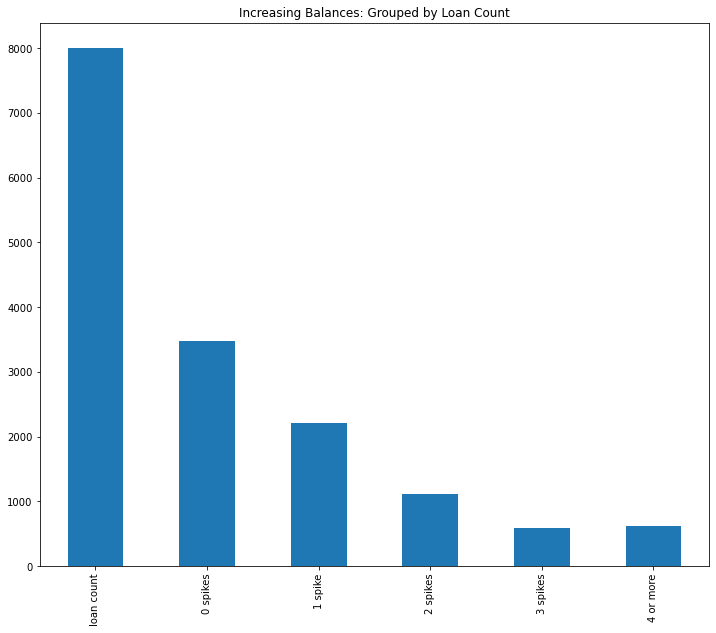

In [699]:
# y_refine = count_increasing_balances(cohort_map, loans, 1)

# print(y_refine)
# print(id_list)
my_dict = {'loan count': 7992, '0 spikes': 3471, '1 spike': 2207,'2 spikes': 1108, '3 spikes': 584, '4 or more': 622}
y_ref = pd.DataFrame.from_dict(my_dict, orient='index')

y_ref.plot(kind='bar', figsize=(12,10), title='Increasing Balances: Grouped by Loan Count', rot=90, legend=False)

In [588]:
t = pd.DataFrame.from_dict(y_refine['2000']['ids'], orient='index')
t.columns = ['Yrs']
t = t.reset_index()
t = t.rename(columns={'index':'obs_nmb'})

<AxesSubplot:title={'center':'Years till Maturity for 2000 Loans with 1 or More Balance Spikes, labeled "Non-Revolving"\nYear 2000'}, xlabel='Years till Maturity', ylabel='Loan Count'>

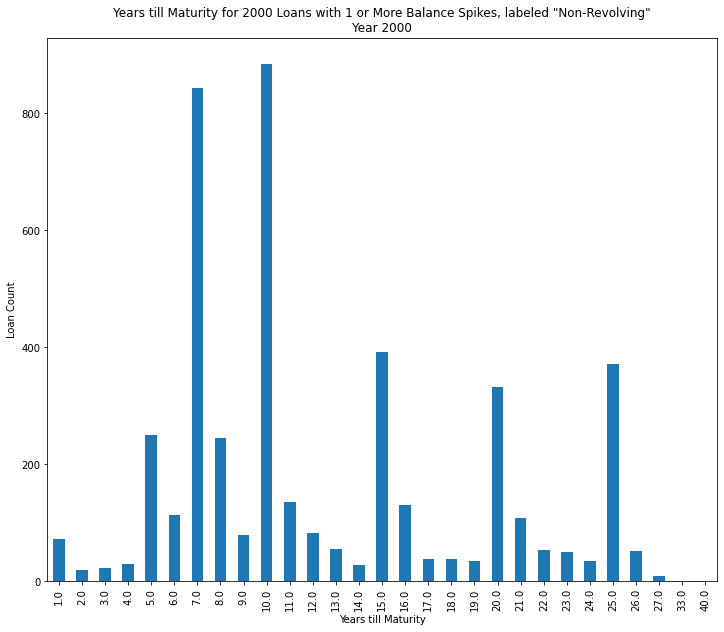

In [606]:
t.groupby('Yrs').count().sort_index().plot(kind='bar', figsize=(12,10), title='Years till Maturity for 2000 Loans with 1 or More Balance Spikes, labeled "Non-Revolving"\nYear 2000',
                                          ylabel='Loan Count', xlabel='Years till Maturity' ,legend=False)

In [607]:
t[t.Yrs<=10]

,obs_nmb,Yrs
0,1469636,5.00
1,1469642,7.00
2,1469643,5.00
4,1469649,7.00
8,1469669,5.00
...,...,...
4508,2016478,10.00
4509,2016497,7.00
4510,2016519,10.00
4517,2016577,6.00


In [669]:
testing = pd.read_csv('csvs\years_till_maturityREVOLVERS_2000.csv')

In [670]:
testing = testing.groupby('Years Till Maturity').count()[['ObservationNmb']]

In [ ]:
testing.plot(kind='bar', figsize=(12,10), title='Years till Maturity for Revolvers\nYear 2000',
                                          ylabel='Loan Count', xlabel='Years till Maturity' ,legend=False)

In [ ]:
t.loc[t.Yrs<=10]

GP: 2007445
local maximum:[27]

local minimum:[26]


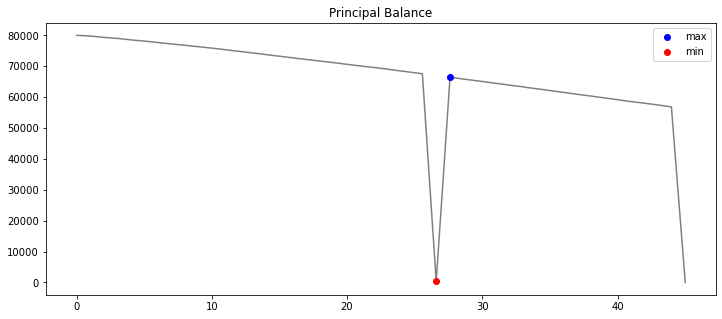

In [691]:
import random
import matplotlib.pyplot as plt
i = random.choice(list(cohort_map['2000'].keys()))
print(f"GP: {'2007445'}")
def explore_sample_peakfinding(input_index:int):
    try:
        sample = set_top_bot(cohort_map['2000']['2007445'])
        my_arr = sample['TransactionBalanceAmt'].values
        x = np.linspace(0,len(my_arr),my_arr.shape[0])
                # local min & max
        b = (np.diff(np.sign(np.diff(my_arr))) > 0).nonzero()[0] + 1         # local min
        c = (np.diff(np.sign(np.diff(my_arr))) < 0).nonzero()[0] + 1         # local max
        # +1 due to the fact that diff reduces the original index number
        plt.figure(figsize=(12,5))
        plt.plot(x, my_arr, color='grey')
        plt.plot(x[c], my_arr[c], "o", label="max", color='b')
        plt.plot(x[b], my_arr[b], "o", label="min", color='r')
        plt.legend()
        plt.title('Principal Balance')
        print(f"local maximum:{c}\n")
        print(f"local minimum:{b}")
        return plt.show(), c, b, i
    except AttributeError:
        return('Nonetype found, run again')
    
_, idx_max, idx_min, i = explore_sample_peakfinding(i)

### Resolve 1 Balance Spike where there was an accounting error

In [750]:
e_codes = set(['195', '218', '305', '410', '416'])
test = set_top_bot(cohort_map['2000']['2007445'].copy())
test = test.rename(columns={'ObservationNmb':'TEST'})
test['TransactionBalanceAmt'] = pd.to_numeric(test['TransactionBalanceAmt'])
test['TransactionAmt'] = pd.to_numeric(test['TransactionAmt'])
x_max = test.loc[test.index.isin(idx_max)]
x_min = test.loc[test.index.isin(idx_min)]
display(list(test.loc[test.index.isin(idx_max)]['Transactioncd'].values))
min_row= x_min['TransactionBalanceAmt'].idxmin()
max_row = x_max['TransactionBalanceAmt'].idxmax()
test.at[min_row, 'TransactionBalanceAmt'] = -1*(test.at[min_row, 'TransactionAmt'])
test.at[max_row, 'TransactionAmt'] = -1*(test.at[min_row, 'TransactionBalanceAmt'] - test.at[max_row, 'TransactionBalanceAmt'])
test.at[min_row, 'TransactionAmt'] = -1*(test.at[min_row-1, 'TransactionBalanceAmt'] - test.at[min_row, 'TransactionBalanceAmt'])


[455]

In [753]:
e_codes = set(['195', '218', '305', '410', '416','455']) 
v = set(list(test.loc[test.index.isin(idx_max)]['Transactioncd'].values))

e_codes.intersection(v)

set()

In [754]:
v

{455}

<AxesSubplot:>

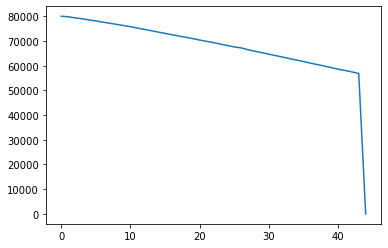

In [722]:
test['TransactionBalanceAmt'].plot()

In [725]:
test['TransactionBalanceAmt'].is_monotonic_decreasing

True

In [732]:
master_df = pd.concat(cohort_map['2000'])

In [733]:
master_df['LoanFundedDt'] = master_df['Origination_dt']
master_df = master_df.drop(columns='Origination_dt')

In [739]:
master_df = master_df[['ObservationNmb','LoanFundedDt', 'MaturityDt', 'EffectiveDt', 'Transactioncd','GeneralLedgerCd', 'TransactionAmt', 'TransactionBalanceAmt',]]

In [746]:


# Where T-code 195 and Balance>0 AND transactionAmt matches transaction balance amt
master_df.loc[(master_df.TransactionBalanceAmt>0)&(master_df.Transactioncd==305)&(master_df.TransactionAmt == master_df.TransactionBalanceAmt)]



# .groupby('ObservationNmb')[['TransactionBalanceAmt']].count().sort_values(by='TransactionBalanceAmt', ascending=False)

,,ObservationNmb,LoanFundedDt,MaturityDt,EffectiveDt,Transactioncd,GeneralLedgerCd,TransactionAmt,TransactionBalanceAmt
1497032,22,1497032,2000-05-02,2008-01-31,2010-09-28,305,1510,44859.50,44859.50
2008051,20,2008051,2000-10-17,2020-12-31,2007-10-15,305,1510,450235.00,450235.00
2015734,32,2015734,2000-12-21,2016-01-31,2008-05-08,305,1510,0.01,0.01


In [8]:

for i in tqdm( range(len(cohort_map['2000'])) ):
    df = cohort_map['2000'][i]
    df = cleaning_step_1(df)
    df_l = cleaning_step_2(df)
    df = cleaning_step_3(df_l)
    cohort_map['2000'][i] = df
    

  0%|          | 0/9318 [00:00<?, ?it/s]c:\Users\Laramie\anaconda3\envs\dev\lib\site-packages\numpy_financial\_financial.py:226: RuntimeWarning: invalid value encountered in double_scalars
  return -(fv + pv*temp) / fact
 27%|██▋       | 2560/9318 [01:07<02:36, 43.20it/s]c:\Users\Laramie\anaconda3\envs\dev\lib\site-packages\numpy_financial\_financial.py:226: RuntimeWarning: divide by zero encountered in double_scalars
  return -(fv + pv*temp) / fact
100%|██████████| 9318/9318 [04:03<00:00, 38.20it/s]


### Smoothing Payoff Functions

In [510]:
sample = cohort_map['2000'][320].reset_index()
sample['Actual Balance'] = pd.to_numeric(sample['Actual Balance'])
sample['Actual Principal'] = pd.to_numeric(sample['Actual Principal'])
sample['delta'] = sample['Actual Balance'].pct_change().round(4)

<AxesSubplot:>

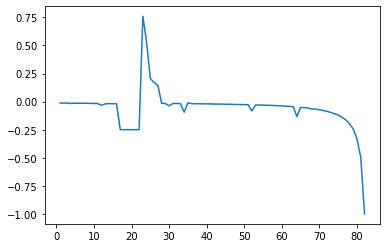

In [511]:
idx = sample.iloc[2:].loc[(sample.delta==np.inf)|(sample.delta>0)].index
idx

for i in idx:
    sample.loc[i-2:i+1].iloc[1:3][['Actual Principal','Actual Balance']] = np.nan
    sample['Actual Balance'] = sample['Actual Balance'].interpolate()
    sample.loc[i-2:i+1].iloc[1:3]['Actual Principal'] = sample.loc[i-2:i+1].iloc[1:3]['Actual Balance'].diff()
    sample['delta'] = sample['Actual Balance'].pct_change().round(4)


sample['delta'].plot()

In [7]:
def cleaning_step_1(d:pd.DataFrame)-> pd.DataFrame:
    e_codes = {195, 218, 305, 410}
    # Format Columns
    d = d.rename(columns={'Origination_dt':'LoanFundedDt'})
    d['LoanFundedDt'] = pd.to_datetime(d['LoanFundedDt'])
    d['MaturityDt'] = pd.to_datetime(d['MaturityDt'])
    d['EffectiveDt'] = pd.to_datetime(d['EffectiveDt'])
    d['TransactionBalanceAmt'] = pd.to_numeric(d['TransactionBalanceAmt'])
    d['TransactionAmt'] = pd.to_numeric(d['TransactionAmt'])
    d['delta'] = d['TransactionBalanceAmt'].pct_change().round(5)
    # Identify first 0 balance
    d['PaidOff']= 0
    try:
        d['PaidOff'] = 0
        idx = d.loc[d['TransactionBalanceAmt']==0].iloc[0].name
        d.at[idx, 'PaidOff'] = 1
    except IndexError:
        pass
    # Identify subset of end codes that would END IO revenues from the loan
    # 195, 218, 305, 410
    d['e_code'] = 0
    try:
        d.loc[d.Transactioncd.isin(e_codes), 'e_code'] = 1    
    except IndexError:
        pass
    d['MnthsFrom_Origination'] = (d['EffectiveDt']-d['LoanFundedDt'])/np.timedelta64(1,'M')
    try:
        d['MnthsFrom_Origination'] = d['MnthsFrom_Origination'].astype(float).round(1)
    except:
        pass
        
    d['MnthsFrom_Maturity'] = (d['MaturityDt']-d['EffectiveDt'])/np.timedelta64(1,'M')
    try:
        d['MnthsFrom_Maturity'] = d['MnthsFrom_Maturity'].astype(int)
    except:
        pass
    # remove rows positive delta and an end code is present
    try:
        idx = d.loc[(d.delta>=0)&(d.e_code>0)].index
        d = d.drop(idx)
    except IndexError:
        pass

    # Cleaning the data set:
    # 1) Remove transactions that record matching negative balances. These loans have payment strings whose effectivedates are likely in the 
    # wrong order
    scuffed_data = d[(d['TransactionBalanceAmt'].values==d['TransactionAmt'].values) \
                & (d['TransactionAmt']<0)].index.to_list()
    d= d.drop(scuffed_data, axis=0)
    
    # 2) Remove loans who's first payment is over 6 months from the OriginationDt. These loans either should have been recorded as 2001 vintage or 
    # the payment strings have incorrect effictive dates
    # 2a) sort by origination, effectivedt, observationnmb, then the TransactionBalanceAmt
    # missed_funding_window = d.sort_values(by = ['LoanFundedDt', 'EffectiveDt', 'ObservationNmb', 'TransactionBalanceAmt'] )
    # # 2b) groupby observation number, taking the first transaction for each loan
    # # This SETS THE INDEX TO OBSERVATION NMB
    # missed_funding_window = missed_funding_window.groupby('ObservationNmb').first()
    # # 2c) set the window to only those loans whose first transaction occured in 2001
    # missed_funding_window = missed_funding_window[missed_funding_window['EffectiveDt'].dt.year == 2001]
    # # 2d) create the test column that we will use to test if a loan is outside its funding window
    # # 2e) create list of indexes outside the funding window -- do not include previously grabbed indexes
    # more_s_data = missed_funding_window[missed_funding_window['MnthsFrom_Origination'] > 6][['TransactionBalanceAmt']].index.to_list()
    # d = d.set_index('ObservationNmb')
    # d = d.drop(more_s_data, axis=0).reset_index()

    # 3) Drop out rows with TransactionAmounts of 1 dollar or less. I have not been able to find a discernible reason I would want those records in a payment string
    # Usually the result of accounting errors or adhoc principal adjustments we don't need.
    scuffed_data = d[(d['TransactionAmt']<=1)&(d['TransactionAmt']>=-1)].index.to_list()

    d= d.drop(scuffed_data, axis=0)
    # 4) Take the earliest payoff date if duplicate payoff dates exist. There will still be multiple payoff dates, but this gets rid of roughly 700 duplicate
    # entries that have the same effect with different codes 
    d =d.drop_duplicates(subset=['ObservationNmb', 'PaidOff', 'TransactionAmt', 'TransactionBalanceAmt'], keep='first')

    # Remove spike balances (not all increasing balances will be removed here, but this gets a good number)
    # idx = d.iloc[2:].loc[(d.delta==np.inf)|(d.delta>0)].index
    # idx
    # for i in idx:
    #     try:
    #         d.loc[i-2:i+1].iloc[1:3][['TransactionAmt','TransactionBalanceAmt']] = np.nan
    #         d['TransactionBalanceAmt'] = d['TransactionBalanceAmt'].interpolate()
    #         d.loc[i-2:i+1].iloc[1:3]['TransactionAmt'] = d.loc[i-2:i+1].iloc[1:3]['TransactionBalanceAmt'].diff()
    #         d['delta'] = d['TransactionBalanceAmt'].pct_change().round(4)
    #     except:
    #         pass
    # return d
print('creating amortization look_up table...')
amortization_lookup = create_amortization_lookup(engine_obj=engine)
amortization_lookup = amortization_lookup.set_index('ObservationNmb')
amortization_lookup= amortization_lookup.fillna(0)
from prepay_utilities import create_amortization_lookup, amortize    
def cleaning_step_2(d:pd.DataFrame)->list:
    try:
        num = d['ObservationNmb'][0]
        lf_dt = d['LoanFundedDt'][0]
        m_dt = d['MaturityDt'][0]
        interest_rate = amortization_lookup.loc[num]['BankInterestPct']
        if amortization_lookup.loc[num]['GrossGtyDisbursementAmt']==0:
            loan_amt = d['TransactionBalanceAmt'].max()
        else: 
            loan_amt = amortization_lookup.loc[num]['GrossGtyDisbursementAmt']
        try:
            months = int( pd.Timedelta(m_dt - lf_dt)/np.timedelta64(1, 'M'))
        except TypeError:
            months = amortization_lookup.loc[num]['MaturityMthsQty']
        return [d, pd.DataFrame(amortize(interest_rate, loan_amt, months))]
    except:
        return None

def cleaning_step_3(df_list:list)->pd.DataFrame:
    try:    
        df_actual = df_list[0]
        df_actual.rename(columns={'TransactionAmt': 'Actual Principal', 
                        'TransactionBalanceAmt': 'Actual Balance'}, inplace=True)
        df_actual.set_index(pd.RangeIndex(df_actual.shape[0]), inplace=True)

        df_scheduled = df_list[1][['Scheduled Principal','Begging Loan Balance','Ending Loan Balance']]
        df_scheduled.rename(columns={'Begging Loan Balance':'EstimateBegBal',
                            'Ending Loan Balance': 'EstimateEndBal'}, inplace=True)
        df_scheduled = df_scheduled.shift(1)
        df_scheduled.set_index(pd.RangeIndex(df_scheduled.shape[0]), inplace=True)
        
        merged = df_scheduled.merge(df_actual, left_index=True, right_index=True, how='outer')
        merged['Difference_p'] = merged['Actual Balance'].diff()
        
        merged.loc[(merged['Actual Principal']<0), 'Difference_from_estimat'] = (merged['Scheduled Principal']+merged['Actual Principal'])
        
        
        # Chop length of dataframe by getting rid of unnessecary rows (payment string has ended but amortization continues)
        chop_here = (merged[merged.ObservationNmb.isnull()].iloc[0].name)
        merged = merged.iloc[0:chop_here]
        return merged
    except:
        return None


creating amortization look_up table...


In [319]:
e_codes = {195, 218, 305, 410}
# for d in cohort_map['2000'][0:1]:

# Format Columns
d = cohort_map['2000'][0]
d = d.rename(columns={'Origination_dt':'LoanFundedDt'})
d['LoanFundedDt'] = pd.to_datetime(d['LoanFundedDt'])
d['MaturityDt'] = pd.to_datetime(d['MaturityDt'])
d['EffectiveDt'] = pd.to_datetime(d['EffectiveDt'])
d['TransactionBalanceAmt'] = pd.to_numeric(d['TransactionBalanceAmt'])
d['TransactionAmt'] = pd.to_numeric(d['TransactionAmt'])
d['delta'] = d['TransactionBalanceAmt'].pct_change().round(5)
# Identify first 0 balance
d['PaidOff']= 0
try:
    d['PaidOff'] = 0
    idx = d.loc[d['TransactionBalanceAmt']==0].iloc[0].name
    d.at[idx, 'PaidOff'] = 1
except IndexError:
    pass
# Identify subset of error codes that would end IO revenues from the loan
# 195, 218, 305, 410
d['e_code'] = 0
try:
    d.loc[d.Transactioncd.isin(e_codes), 'e_code'] = 1    
except IndexError:
    pass
d['MnthsFrom_Origination'] = (d['EffectiveDt']-d['LoanFundedDt'])/np.timedelta64(1,'M')
d['MnthsFrom_Origination'] = d['MnthsFrom_Origination'].astype(float).round(1)
    
d['MnthsFrom_Maturity'] = (d['MaturityDt']-d['EffectiveDt'])/np.timedelta64(1,'M')
d['MnthsFrom_Maturity'] = d['MnthsFrom_Maturity'].astype(int)
# remove rows positive delta and an encode is present
try:
    idx = d.loc[(d.delta>=0)&(d.e_code>0)].index
    d = d.drop(idx)
except IndexError:
    pass
print('cleaning...\n')
# Cleaning the data set:
# 1) Remove transactions that record matching negative balances. These loans have payment strings whose effectivedates are likely in the 
# wrong order
scuffed_data = d[(d['TransactionBalanceAmt'].values==d['TransactionAmt'].values) \
            & (d['TransactionAmt']<0)].index.to_list()
d= d.drop(scuffed_data, axis=0)
# 2) Remove loans who's first payment is over 6 months from the OriginationDt. These loans either should have been recorded as 2001 vintage or 
# the payment strings have incorrect effictive dates
# 2a) sort by origination, effectivedt, observationnmb, then the TransactionBalanceAmt
missed_funding_window = d.sort_values(by = ['LoanFundedDt', 'EffectiveDt', 'ObservationNmb', 'TransactionBalanceAmt'] )
# 2b) groupby observation number, taking the first transaction for each loan
# This SETS THE INDEX TO OBSERVATION NMB
missed_funding_window = missed_funding_window.groupby('ObservationNmb').first()
# 2c) set the window to only those loans whose first transaction occured in 2001
missed_funding_window = missed_funding_window[missed_funding_window['EffectiveDt'].dt.year == 2001]
# 2d) create the test column that we will use to test if a loan is outside its funding window
# 2e) create list of indexes outside the funding window -- do not include previously grabbed indexes
more_s_data = missed_funding_window[missed_funding_window['MnthsFrom_Origination'] > 6][['TransactionBalanceAmt']].index.to_list()
d = d.set_index('ObservationNmb')
print('cleaning...\n')
d = d.drop(more_s_data, axis=0).reset_index()
# 3) Drop out rows with TransactionAmounts of 1 dollar or less. I have not been able to find a discernible reason I would want those records in a payment string
# Usually the result of accounting errors or adhoc principal adjustments we don't need.
scuffed_data = d[(d['TransactionAmt']<=1)&(d['TransactionAmt']>=-1)].index.to_list()
print('cleaning...\n')
d= d.drop(scuffed_data, axis=0)
# 4) Take the earliest payoff date if duplicate payoff dates exist. There will still be multiple payoff dates, but this gets rid of roughly 700 duplicate
# entries that have the same effect with different codes 
d =d.drop_duplicates(subset=['ObservationNmb', 'PaidOff', 'TransactionAmt', 'TransactionBalanceAmt'], keep='first')
print("cleaning...")
# Remove spike balances (not all increasing balances will be removed here, but this gets a good number)
idx = d.iloc[2:].loc[(d.delta==np.inf)|(d.delta>0)].index
idx
for i in idx:
    try:
        d.loc[i-2:i+1].iloc[1:3][['TransactionAmt','TransactionBalanceAmt']] = np.nan
        d['TransactionBalanceAmt'] = d['TransactionBalanceAmt'].interpolate()
        d.loc[i-2:i+1].iloc[1:3]['TransactionAmt'] = d.loc[i-2:i+1].iloc[1:3]['TransactionBalanceAmt'].diff()
        d['delta'] = d['TransactionBalanceAmt'].pct_change().round(4)
    except:
        pass







cleaning...

cleaning...

cleaning...

cleaning...


In [220]:
from prepay_utilities import show_slice

cohort_map['2000'][319]

,Scheduled Principal,EstimateBegBal,EstimateEndBal,ObservationNmb,LoanFundedDt,MaturityDt,EffectiveDt,Transactioncd,GeneralLedgerCd,Actual Principal,Actual Balance,delta,PaidOff,e_code,MnthsFrom_Origination,MnthsFrom_Maturity,Difference_p,Difference_from_estimat
0,NaN,NaN,NaN,1482170,2000-01-12,2025-01-31,2000-01-31,455,6031,525423.00,525423.00,NaN,0.00,0.00,0.60,300.00,NaN,NaN
1,1038.00,1500000.00,1498962.00,1482170,2000-01-12,2025-01-31,2000-03-31,455,6031,NaN,681204.00,0.30,0.00,0.00,2.60,298.00,155781.00,NaN
2,1047.00,1498962.00,1497915.00,1482170,2000-01-12,2025-01-31,2000-04-30,455,6031,NaN,954136.00,0.40,0.00,0.00,3.60,297.00,272932.00,NaN
3,1056.00,1497915.00,1496859.00,1482170,2000-01-12,2025-01-31,2000-05-31,455,6031,NaN,1135984.00,0.19,0.00,0.00,4.60,296.00,181848.00,NaN
4,1065.00,1496859.00,1495794.00,1482170,2000-01-12,2025-01-31,2000-06-30,455,6031,181848.00,1317832.00,0.16,0.00,0.00,5.60,295.00,181848.00,NaN
5,1075.00,1495794.00,1494719.00,1482170,2000-01-12,2025-01-31,2001-03-31,455,6031,-315.34,1499680.00,0.14,0.00,0.00,14.60,286.00,181848.00,759.66
6,1084.00,1494719.00,1493635.00,1482170,2000-01-12,2025-01-31,2001-04-30,455,6031,-816.94,1498870.00,-0.00,0.00,0.00,15.60,285.00,-810.00,267.06
7,1094.00,1493635.00,1492541.00,1482170,2000-01-12,2025-01-31,2001-05-31,455,6031,-2318.84,1496550.00,-0.00,0.00,0.00,16.60,284.00,-2320.00,-1224.84
8,1103.00,1492541.00,1491438.00,1482170,2000-01-12,2025-01-31,2001-06-30,455,6031,-1496550.00,0.00,-1.00,1.00,0.00,17.60,283.00,-1496550.00,-1495447.00


In [132]:
master_2000 = pd.concat(cohort_map['2000'])
# 2) Remove loans who's first payment is over 6 months from the OriginationDt. These loans either should have been recorded as 2001 vintage or 
# the payment strings have incorrect effictive dates
# 2a) sort by origination, effectivedt, observationnmb, then the TransactionBalanceAmt
missed_funding_window = master_2000.sort_values(by = ['LoanFundedDt', 'EffectiveDt', 'ObservationNmb', 'Actual Principal'] )
# 2b) groupby observation number, taking the first transaction for each loan
# This SETS THE INDEX TO OBSERVATION NMB
missed_funding_window = missed_funding_window.groupby('ObservationNmb').first()
# 2c) set the window to only those loans whose first transaction occured in 2001
missed_funding_window = missed_funding_window[missed_funding_window['EffectiveDt'].dt.year == 2001]
# 2d) create the test column that we will use to test if a loan is outside its funding window
# 2e) create list of indexes outside the funding window -- do not include previously grabbed indexes
more_s_data = missed_funding_window[missed_funding_window['MnthsFrom_Origination'] > 6][['Actual Principal']].index.to_list()
master_2000 = master_2000.set_index('ObservationNmb')
master_2000 = master_2000.drop(more_s_data, axis=0).reset_index()
master_2000['Month'] = master_2000['EffectiveDt'].dt.month
master_2000['Year'] = master_2000['EffectiveDt'].dt.year
master_2000 = master_2000[master_2000['EffectiveDt'].dt.year != 1960]
master_2000['Difference_l'] = 0
master_2000.loc[master_2000['Difference_p']<0, 'Difference_l'] = master_2000.Difference_p + master_2000['Scheduled Principal']
inspect = master_2000[(master_2000.Year==2009) & (master_2000.Month==6)]
idx = inspect[inspect['delta'] > 0].index
# master_copy = master_2000.drop(idx)
# master_copy[(master_copy.Year==2009) & (master_copy.Month==6) & (master_copy.delta)]['Actual Balance'].sum()


In [205]:
cohort_map['2000'][320]['ObservationNmb']

0     1482171
1     1482171
2     1482171
3     1482171
4     1482171
       ...   
78    1482171
79    1482171
80    1482171
81    1482171
82    1482171
Name: ObservationNmb, Length: 83, dtype: object

In [191]:
# test = master_2000[master_2000.MnthsFrom_Maturity>=300].groupby('ObservationNmb').first()
# test['Diff_'] = ((test['LoanFundedDt'] - test['MaturityDt']) / np.timedelta64(1,'M'))
test = master_2000.groupby(['ObservationNmb', 'Year', 'Month']).first().reset_index()

s = test[test['delta']>0]['ObservationNmb'].value_counts()
idx = s[s>2].index

test = master_2000[~master_2000['ObservationNmb'].isin(idx)]

test2 = master_2000.groupby(['ObservationNmb', 'Year', 'Month']).last().reset_index()
test2[(test2['PaidOff']==1)&(test2['delta']<0)]['Difference_l'].sum()

-1164606777.0798826

In [197]:
master_2000.groupby(['Year', 'Month']).sum()[['Difference_l']].sum()

Difference_l   -1834662856.92
dtype: float64

In [201]:
test.groupby(['ObservationNmb','Year','Month'])[['Difference_l']].sum().reset_index().groupby(['Year','Month']).sum().sum()

Difference_l   -1242102454.48
dtype: float64

In [ ]:
missed_funding_window = master_2000.sort_values(by = ['LoanFundedDt', 'EffectiveDt', 'ObservationNmb', 'Actual Principal'] )
# 2b) groupby observation number, taking the first transaction for each loan
# This SETS THE INDEX TO OBSERVATION NMB
missed_funding_window = missed_funding_window.groupby('ObservationNmb').first()
# 2c) set the window to only those loans whose first transaction occured in 2001
missed_funding_window = missed_funding_window[missed_funding_window['EffectiveDt'].dt.year == 2001]

missed_funding_window

In [202]:
df1 = test.groupby(['Year','Month'])[['Actual Balance']].sum().reset_index()
df2 = test.groupby(['ObservationNmb','Year','Month'])[['Difference_l']].sum().reset_index().groupby(['Year','Month']).sum().reset_index()

df1.merge(df2, how='outer', on=['Year','Month']).to_csv('csvs/filter_all_increasing_balances.csv', mode='w')

In [453]:
obs=master_copy[(master_copy.Year==2000)&(master_copy.Month==1)]['ObservationNmb'].to_list()

test_df = master_copy.loc[master_copy['ObservationNmb'].isin(obs)]
df1 = test_df.groupby(['ObservationNmb','Year','Month'])[['Actual Balance']].sum().reset_index().groupby(['Year','Month']).sum().reset_index()
df2 = test_df.groupby(['ObservationNmb','Year','Month'])[['Difference_l']].sum().reset_index().groupby(['Year','Month']).sum().reset_index()

df1.merge(df2, how='outer', on=['Year','Month']).to_csv('csvs/12-16/2000-1_2.csv')

In [466]:
test_df = master_2000[['Year','Month','ObservationNmb']].groupby('ObservationNmb').first().reset_index()

test_df.sort_values(['Year', 'Month'])



,ObservationNmb,Year,Month
0,1469636,2000,1
21,1476786,2000,1
23,1478270,2000,1
26,1480769,2000,1
27,1480771,2000,1
...,...,...,...
6472,2010759,2004,5
5512,1515286,2004,6
6378,2010100,2005,1
4217,1506074,2005,3


In [129]:

arr = sample['delta'].to_list()

def bsearch_removal(array, low, high, num_runs):
    num_runs -=1
    test_list = array[:]
    pos_idx = []
    found_positive = False
    found_negative = False
    while low <= high:
        mid = low + (high - low)//2
        if test_list[mid] > 0:
            pos_idx.append(mid)
            found_positive = True
            temp = mid - 1 
        while found_positive:
            if temp < low:
                found_positive = False   
            elif test_list[temp] >= 0:
                pos_idx.append(temp)
            else:
                found_positive = False  
                found_negative = True
                temp = mid + 1
                while found_negative:
                    if temp > high:
                        found_negative = False
                    elif test_list[temp] >= 0:
                        pos_idx.append(temp)
                    else:
                        found_negative = False
                    temp += 1
            temp -= 1
        else:
            high = mid -1    
    for i in sorted(pos_idx, reverse=True):
        del test_list[i]
    if num_runs == 0:
        return test_list 
    else: 
        return bsearch_removal(test_list,0,len(test_list)-1, num_runs)

test = bsearch_removal(arr, 0, len(arr)-1, 50)
original = pd.Series(arr)
    


In [475]:
from prepay_utilities import show_slice

test = show_slice(master_2000, '2016246')

test[['Actual Principal', 'Transactioncd' , 'GeneralLedgerCd' ,'Actual Balance']]

,Actual Principal,Transactioncd,GeneralLedgerCd,Actual Balance
369260,-6180.56,455,6031,185279.00
369261,191459.00,455,6031,191459.00
369262,-18404.10,455,6031,166875.00
369263,-166875.00,455,6031,0.00


<AxesSubplot:>

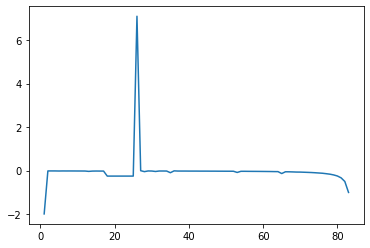

In [130]:
display(pd.Series(test).plot())
# display(original.plot())

#### first shot -- not bad

3618
34 34


<AxesSubplot:>

<AxesSubplot:>

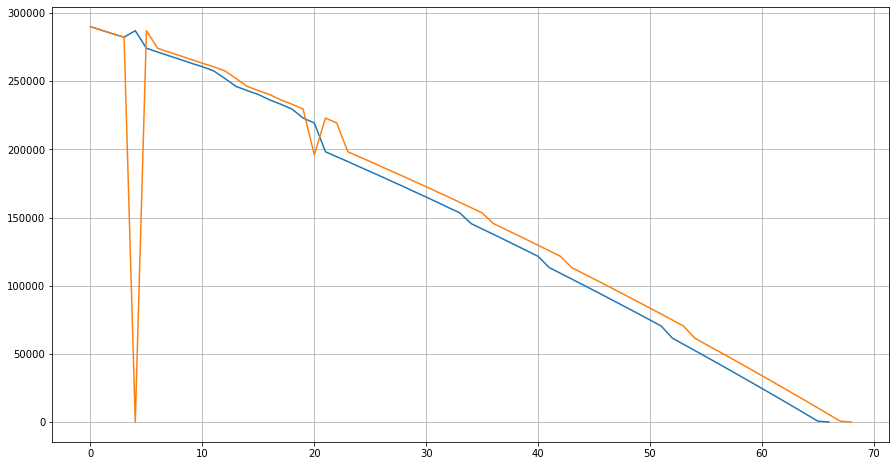

In [606]:
def smoothe_payoffs(num:int)->None:
    my_list = cohort_map['2000'][num]['TransactionBalanceAmt'].to_list()
    print(num)
    original = pd.Series(my_list)
    remove_rows = []

    condition = True

    p1 = 0
    p2 = len(my_list)-1
    # print(p1,p2)
    while condition:
        try:
            p1+=1
            p2-=1
            if abs(p1-p2)<=1:
                print(p1,p2)
                condition = False
            # If the current value is increasing going forward in time       
            if my_list[p1] >= my_list[p1-1]:
                remove_rows.append(p1-1)
            # If the previous value was less going backward in time
            if my_list[p2] <= my_list[p2+1]:
                remove_rows.append(p2+2)
                
        except IndexError:
            print(p1)
            break



    for i in sorted(remove_rows, reverse=True):
        del my_list[i]
        

    display(pd.Series(my_list).plot(figsize=(15,8), grid=True))
    display(original.plot(grid=True))

    return None
import random
smoothe_payoffs(random.choice(list(range(0,9000))))

#### second shot

62 61
[96, 100]
[450000.0, 447713.0, 446275.0, 445109.0, 443912.0, 441947.0, 440215.0, 438304.0, 436629.0, 434406.0, 431999.0, 429573.0, 427331.0, 424606.0, 422060.0, 419606.0, 416396.0, 412836.0, 409750.0, 406319.0, 403273.0, 401648.0, 398664.0, 396831.0, 394353.0, 391782.0, 390998.0, 388350.0, 383353.0, 382636.0, 378039.0, 377203.0, 375151.0, 373089.0, 371348.0, 369199.0, 367106.0, 361283.0, 359114.0, 357173.0, 354956.0, 352894.0, 351137.0, 349508.0, 347124.0, 346096.0, 344080.0, 342173.0, 340539.0, 338463.0, 336911.0, 334876.0, 332463.0, 329740.0, 326746.0, 324893.0, 322394.0, 320236.0, 318089.0, 315694.0, 313520.0, 310709.0, 308884.0, 305777.0, 304179.0, 301667.0, 298954.0, 296484.0, 294515.0, 289315.0, 288952.0, 286305.0, 283719.0, 281193.0, 278312.0, 275817.0, 273054.0, 269911.0, 267440.0, 264643.0, 261548.0, 258514.0, 256455.0, 253080.0, 248955.0, 246425.0, 242518.0, 239427.0, 235113.0, 232033.0, 227834.0, 224085.0, 220562.0, 218279.0, 215045.0, 161283.0, 199688.0, 196346.0, 192

<AxesSubplot:>

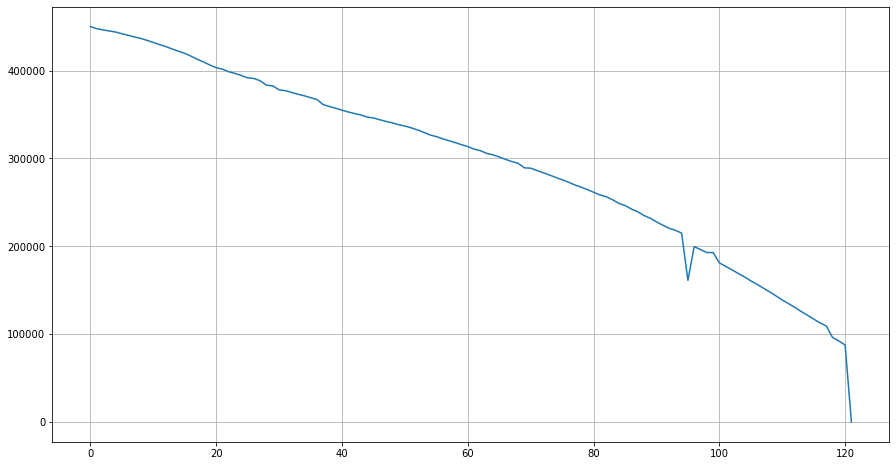

In [594]:
my_list = cohort_map['2000'][5657]['TransactionBalanceAmt'].to_list()
original = pd.Series(my_list)
remove_rows = []

condition = True
p1 = 0
p2 = len(my_list)-1
# print(p1,p2)
while condition:
    try:
        p1+=2
        p2-=2
        if abs(p1-p2)<=2:
            print(p1,p2)
            condition = False
        # If the current value is increasing going forward in time       
        if not my_list[p1-2] >= my_list[p1-1] >= my_list[p1]:
            remove_rows.append(p1-1)
        # If the previous value was less going backward in time
        if not my_list[p2+2] <= my_list[p2+1] <= my_list[p2]:
            remove_rows.append(p2+1)
            
    except IndexError:
        print(p1, p2)
        break
print(sorted(remove_rows))
for i in sorted(remove_rows, reverse=True):
    del my_list[i]
    
print(my_list)
display(pd.Series(my_list).plot(figsize=(15,8), grid=True))
# display(original.plot(grid=True))


In [511]:
sample = pd.DataFrame(my_list, columns=['principal'])
sample['delta'] = sample.principal.diff()
sample[sample.delta > 0]

,principal,delta
108,183469.00,45046.00


In [478]:
for i in sorted(remove_rows, reverse=True):
    del my_list[i]

<AxesSubplot:>

<AxesSubplot:>

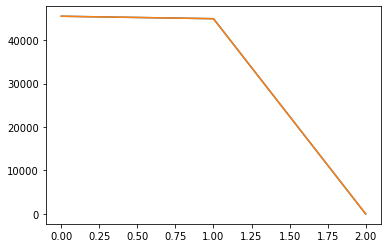

In [479]:
display(pd.Series(my_list).plot())
display(original.plot())

In [468]:
remove_rows

[]

In [ ]:
print('looping through loans...')

sample_dict = {}
for df_x in tqdm(df_list):
    if df_x.any().sum()>0:
        df_x = df_x.drop_duplicates().reset_index().drop(columns='index')

In [ ]:
x = []
ers = []
for i in l:
    initial = 0
    try:
        for s in loans[i].all_pmts:
            if s[3] > initial:
                initial = s[3]
        if initial != 0:
            x.append([loans[i].origination_dt, initial])
    except IndexError:
      ers.append(i)
      


In [158]:
df_notional = pd.DataFrame(data=x, columns=['LoanFundedDt', 'Balance'])
df_notional['LoanFundedDt']= pd.to_datetime(df_notional['LoanFundedDt']) 
df_notional = df_notional.set_index('LoanFundedDt')
df_notional.groupby([(df_notional.index.year), (df_notional.index.month)]).sum().to_csv('notional.csv')

In [154]:
df_notional

,LoanFundedDt,Balance
0,2020-06-26,625000.0
1,2020-06-26,62900.0
2,2020-06-26,38400.0
3,2020-06-15,27000.0
4,2020-06-15,225000.0
...,...,...
98513,2004-12-10,50000.0
98514,2004-12-10,105600.0
98515,2004-12-10,10000.0
98516,2004-12-10,150000.0


In [242]:
prepayment_data = []


errors = []
l = list(loans.keys())
for i in tqdm(l):
    initial = 0
    try:
        for s in loans[i].all_pmts:
            if s[3] > initial:
                initial = s[3]
        if initial != 0:
            notional = initial
    except IndexError:
      errors.append(i)
      pass 
  
    try:
        hist = loans[i].all_pmts
        
        # if hist_6031[ hist_6031[:, 2] == hist_6031[:, 3] ].any(): 
        #     notional1 = (hist_6031[ hist_6031[:, 2] == hist_6031[:, 3] ][0][3])
        # else: notional1= 0
        
        # if hist_1510[ hist_1510[:, 2] == hist_1510[:, 3] ].any():
        #     notional2 = (hist_1510[ hist_1510[:, 2] == hist_1510[:, 3] ][0][3])
        # else: notional2 = 0
        # notional = max(notional1, notional2)
        
        hist = hist[ hist[:, 2] < 0 ]
        hist_1510 = hist[ hist[:, 1]== '1510', :]
        hist_6031 = hist[ hist[:, 1]== '6031', :]
        
        if hist_1510[ hist_1510[:, 3] <= 1001].any():

            if notional >= 10000:
                hist = hist_1510[ hist_1510[:, 3] <= .1*notional][0]
                hist = np.insert(hist, 0, loans[i].origination_dt)
                hist = np.insert(hist,0,i)
                prepayment_data.append(hist)
            else: 
                hist = hist_1510[ hist_1510[:, 3] <= 1001][0]
                hist = np.insert(hist, 0, loans[i].origination_dt)
                hist = np.insert(hist,0,i)
                prepayment_data.append(hist)
            
        elif hist_6031[ hist_6031[:, 3] <= 1001].any():

            if notional >= 10000:
                hist = hist_6031[ hist_6031[:, 3] <= .1*notional][0]
                hist = np.insert(hist, 0, loans[i].origination_dt)
                hist = np.insert(hist,0,i)
                prepayment_data.append(hist)
            else: 
                hist = hist_6031[ hist_6031[:, 3] <= 1001][0]
                hist = np.insert(hist, 0, loans[i].origination_dt)
                hist = np.insert(hist,0,i)
                prepayment_data.append(hist)
                
    except IndexError:
        errors.append(i)
        


100%|██████████| 626914/626914 [1:08:43<00:00, 152.02it/s] 


In [191]:
prepayment_data[0][1].year

2020

In [243]:
df = pd.DataFrame(data= prepayment_data, columns=['ObservationNmb', 'LoanFundedDt', 'date', 'code', 'amount', 'remaining balance'])
df['date'] = pd.to_datetime(df['date'])
df['LoanFundedDt'] = pd.to_datetime(df['LoanFundedDt'])
df = df.set_index('date')
df = df[df.index.year != 1960].sort_index()

In [245]:
df1 = df.reset_index()
df1['amount']= (df1['amount']*-1)
df1['LoanFundedYr'] = df1['LoanFundedDt'].dt.year
df1['LoanFundedMnth'] = df1['LoanFundedDt'].dt.month
df1['EffectiveDtYr'] = df1['date'].dt.year
df1['EffectiveDtMnth'] = df1['date'].dt.month

df1 = df1.set_index(['LoanFundedYr', 'EffectiveDtYr', 'EffectiveDtMnth' ])
df1 = df1[['amount']]

gp_count = df1.groupby(level=['LoanFundedYr', 'EffectiveDtYr', 'EffectiveDtMnth' ]).count()
gp_count = gp_count.reset_index()
gp_count[gp_count['LoanFundedYr']==2000].to_csv('count_all.csv')

gp_amount = df1.groupby(level=['LoanFundedYr', 'EffectiveDtYr', 'EffectiveDtMnth' ]).sum()
gp_amount = gp_amount.reset_index()
gp_amount[gp_amount['LoanFundedYr']==2000].to_csv('total_all.csv')


In [193]:
df1

,ObservationNmb,code,amount,remaining balance
LoanFundedDt,,,,
2000-01-07,1481663,6031,-1242230.00,-1242230.00
2000-02-03,1484715,6031,-77812.50,-77812.50
2000-01-07,1481664,6031,-119250.00,12000.00
2000-01-19,1482782,6031,-62245.20,-62245.20
2000-01-10,1481723,6031,-1400000.00,-1400000.00
...,...,...,...,...
2021-08-02,17973126,6031,-1696.00,0.00
2021-03-15,13477605,6031,-2601400.00,0.00
2020-10-27,10697518,6031,-383237.00,0.00


<AxesSubplot:xlabel='date,date'>

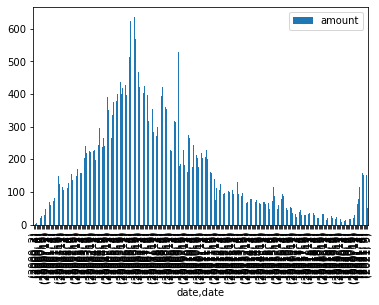

In [186]:
df1 = df[['amount']]
df1['amount'] = df1['amount']*-1
df1.groupby([(df1.index.year), (df1.index.month)]).count().plot(kind='bar')

In [46]:
with engine.connect() as con:
    con.execute('SET GLOBAL innodb_buffer_pool_size=2147483648;')
    query = """SELECT * FROM master_fin WHERE ObservationNmb = "10000625" limit 10;"""
    rows = con.execute(query)
    rvs = list(rows)

In [47]:
rvs

[('10000625', datetime.date(2020, 7, 3), datetime.date(2020, 7, 6), datetime.date(2020, 7, 2), 368, 'P102', '73X4149', '1010', 9375.0, 0.0),
 ('10000625', datetime.date(2020, 8, 6), datetime.date(2020, 8, 6), datetime.date(2020, 7, 31), 298, 'Q996', '7601154', '1010', -1085.66, 0.0),
 ('10000625', datetime.date(2020, 8, 6), datetime.date(2020, 8, 6), datetime.date(2020, 7, 31), 398, 'P995', '73X4149', '1010', 1085.66, 0.0),
 ('10000625', datetime.date(2020, 8, 24), datetime.date(2020, 8, 24), datetime.date(2020, 8, 20), 360, 'P616', '73X4149', '1010', 67.2, 0.0),
 ('10000625', datetime.date(2020, 9, 3), datetime.date(2020, 9, 3), datetime.date(2020, 8, 31), 298, 'Q996', '7601154', '1010', -134.83, 0.0),
 ('10000625', datetime.date(2020, 9, 3), datetime.date(2020, 9, 3), datetime.date(2020, 8, 31), 398, 'P995', '73X4149', '1010', 134.83, 0.0),
 ('10000625', datetime.date(2020, 9, 22), datetime.date(2020, 9, 22), datetime.date(2020, 9, 18), 360, 'P616', '73X4149', '1010', 81.29, 0.0),
 (

In [62]:
match = re.search(r"(\(\')(.+)\'",samp)

if match: 
    print (match.group(2))
else:
    print('fail')

10000625


In [1]:
from pathlib import Path 
import re
import csv

input_file= Path("C:/Users/Laramie/Desktop/data_REVL/fin_all.txt")

# input_file = large text file
# outfile is where we want to put just the id'set 
with open(input_file) as f, open('id_nums.csv', 'wb') as outfile:
    # initialize stuff
    writer = csv.writer(outfile, delimiter=',')
    id_tbl = {}
    # read each line into memory
    for line in f.read():
        # match the first grouping of numbers in the line --> this is always the "ObservationNmb"
        match = re.match(r'(^/d+)' , line )
        if match:
            id = match.group(1)
            writer.writerow(id)
            
    


In [15]:
with open(input_file) as f:
    for line in f:
        print(f"this is the sample line: {line}")
        match = re.match(r'(^\d+)' , line )
        if match:
            print(match.group(1))
        break

this is the sample line: 471382~10/04/1999~10/04/1999~08/31/1999~455~V904~73X4149~6031~-332.53~34719.78

471382
